In [11]:
# basics
import pandas as pd
import numpy as np
import os

# keras deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# preprocessing
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.utils import np_utils

# validation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import LocalOutlierFactor

# interpretability packages
import shap

# basic adversarial example generator
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod

# fixes
import warnings
%matplotlib inline
warnings.filterwarnings('ignore',category=FutureWarning)

In [3]:
# load data
data = load_wine()
X = data['data']
dummy_y = np_utils.to_categorical(data['target'])

# scale X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# create test dataset
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, stratify=data['target'])

In [4]:
# load simple model's weights
simple_model = Sequential()
simple_model.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
simple_model.add(Dense(3, activation='softmax'))
simple_model.load_weights("best-weights-simple_model.hdf5")
simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


# load complex model's weights
complex_model = Sequential()
complex_model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
complex_model.add(Dense(50, activation='relu'))
complex_model.add(Dense(3, activation='softmax'))
complex_model.load_weights("best-weights-complex_model.hdf5")
complex_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [5]:
def multiple_metrics(model, y, x):
    print('classification report, on a testing sample of', x.shape[0])
    print(metrics.classification_report(np.argmax(y,axis = 1), model.predict_classes(x)))
    print('')
    print('ROC-AUC Score on Testing:', metrics.roc_auc_score(y, model.predict_proba(x)))
    print('Cross Entropy Loss:', metrics.log_loss(y,model.predict_proba(x)))
    print('')
    
multiple_metrics(simple_model, y_test, X_test)
multiple_metrics(complex_model, y_test, X_test)

classification report, on a testing sample of 36
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.93      0.96        14
           2       0.91      1.00      0.95        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36


ROC-AUC Score on Testing: 1.0
Cross Entropy Loss: 0.15199867591986227

classification report, on a testing sample of 36
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


ROC-AUC Score on Testing: 1.0
Cross Entropy Loss: 0.044354858682102

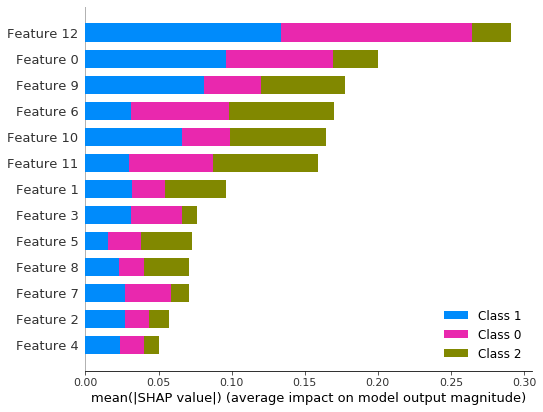

In [25]:
# Interpretability
background = X_test
e = shap.DeepExplainer(complex_model, background)
shap_values = e.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

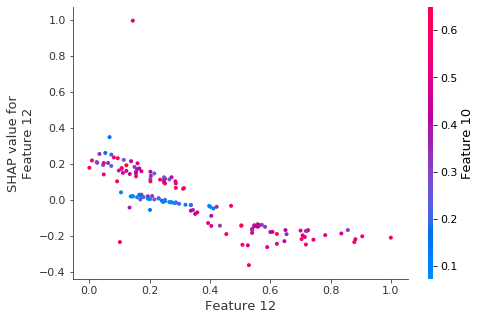

In [27]:
shap.dependence_plot(12, shap_values[1], X_train)

In [7]:
def adversarial_examples(model):
    classifier = KerasClassifier(model=model, use_logits=False)
    probs_adv = classifier.predict(X_test)

    print('Training of ART classifier')
    classifier.fit(X_test, y_test, batch_size=5, nb_epochs=5, verbose = 0)
    #Evaluate the ART classifier on benign test examples
    predictions = classifier.predict(X_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

    #Generate adversarial test examples
    print('Creation of adversarial examples')
    attack = FastGradientMethod(classifier=classifier, eps=0.05)
    x_test_adv = attack.generate(x=X_train)
    print('Adversarial examples created')
    return x_test_adv

print('creation of adversarial examples for simple model')
x_test_adv_simple = adversarial_examples(simple_model)
print('')
print('creation of adversarial examples for simple model')
x_test_adv_complex = adversarial_examples(complex_model)

creation of adversarial examples for simple model
Training of ART classifier
Creation of adversarial examples
Adversarial examples created

creation of adversarial examples for simple model
Training of ART classifier
Creation of adversarial examples
Adversarial examples created


In [8]:
multiple_metrics(simple_model, y_train, x_test_adv_simple)
multiple_metrics(complex_model, y_train, x_test_adv_complex)

classification report, on a testing sample of 142
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        47
           1       0.78      0.86      0.82        57
           2       0.88      0.76      0.82        38

    accuracy                           0.85       142
   macro avg       0.86      0.84      0.85       142
weighted avg       0.85      0.85      0.85       142


ROC-AUC Score on Testing: 0.9759297215311311
Cross Entropy Loss: 0.3357352063594333

classification report, on a testing sample of 142
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        47
           1       0.80      0.86      0.83        57
           2       0.94      0.84      0.89        38

    accuracy                           0.86       142
   macro avg       0.87      0.86      0.86       142
weighted avg       0.86      0.86      0.86       142


ROC-AUC Score on Testing: 0.9734526809546571
Cross 

In [9]:
%run 'psi.py'

<Figure size 432x288 with 0 Axes>

In [10]:
dataset_validation(X_train, x_test_adv_simple)

,column name,baseline mean (std dev),new mean (std dev),stability index,conclusion
0,0,0.52 (0.22),0.5199999809265137 (0.1899999976158142),0.20,Significant change
1,1,0.31 (0.22),0.30000001192092896 (0.20999999344348907),0.11,Some minor change
2,2,0.54 (0.15),0.5299999713897705 (0.14000000059604645),0.21,Significant change
3,3,0.46 (0.18),0.44999998807907104 (0.1599999964237213),0.16,Some minor change
4,4,0.32 (0.16),0.3100000023841858 (0.15000000596046448),0.20,Some minor change
5,5,0.46 (0.22),0.44999998807907104 (0.20999999344348907),0.06,Very slight change
6,6,0.36 (0.21),0.36000001430511475 (0.20000000298023224),0.10,Very slight change
7,7,0.43 (0.24),0.41999998688697815 (0.23000000417232513),0.12,Some minor change
8,8,0.38 (0.18),0.38999998569488525 (0.1899999976158142),0.13,Some minor change
9,9,0.33 (0.2),0.3199999928474426 (0.17000000178813934),0.28,Significant change


In [12]:
clf = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination='auto', n_jobs=-1)
clf.fit(X_train)
print('fitting completed')

# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_val = clf.predict(X_test)
print('prediction of testing dataset completed')

y_pred_new = clf.predict(x_test_adv_simple)
print('prediction of new dataset completed')

n_error_val = y_pred_val[y_pred_val == -1].size
print('error ratio testing dataset: %.2f%%' % (n_error_val / len(y_pred_val)))
n_error_new = y_pred_new[y_pred_new == -1].size
print('error ratio new dataset: %.2f%%' % (n_error_new / len(y_pred_new)))

fitting completed
prediction of testing dataset completed
prediction of new dataset completed
error ratio testing dataset: 0.00%
error ratio new dataset: 0.04%
